In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

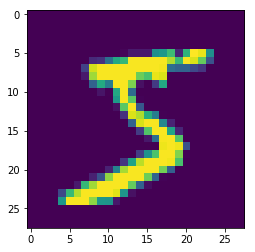

In [107]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

#loading the MNIST data set: MNIST is a dataset of hand drawn numbers
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img1 = x_train[0]

plt.imshow(img1) #show the first image in the dataset



In [108]:
x_train = x_train/255
x_test = x_test/255    #normalize the bits so they are on the same scale

print(np.unique(y_train))
enc = OneHotEncoder(sparse=False) #need to convert the categorical data into one-hot-encoded vectors to be read by Keras

y_train = enc.fit_transform(y_train.reshape(-1,1))   #one hot encode our categories 
y_test = enc.fit_transform(y_test.reshape(-1,1))  # i.e.,0 = [1,0,0,0,0,0,0,0,0,0], 1 = [0,1,0,0,0,0,0,0,0,0], 2 = [0,0,1,0,0,0,0,0,0,0]

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "

In [109]:
x_train_1d = x_train.reshape((len(x_train), 28, 28, 1)) #need to reshape to include channels for running in our CNN (channel numbers have to specified)
x_test_1d = x_test.reshape((len(x_test), 28, 28, 1))
print(x_train_1d[0].shape)


(28, 28, 1)


In [127]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

#BULDING OUR FIRST CNN!!!
model = Sequential()

#64 filters
model.add(Conv2D(64, (3,3), padding="valid", input_shape = (28,28,1), activation="relu")) #valid padding == no padding, which is default
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), padding="valid", activation="relu")) #same padding == keep resulting image the same size
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

#model.add(Conv2D(128, (3,3), activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Flatten()) #need to flatten the layer
model.add(Dense(128, activation="relu")) #run through a dense layer
model.add(Dropout(0.1)) #dropout on this layer to avoid over fitting

model.add(Dense(10, activation="softmax")) #softmax activation for multi-class classification



In [128]:
from tensorflow.keras.optimizers import SGD, Adam


#compile and run our model, same as any NN
adam = Adam(lr=0.001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy']) #categorical_crossentropy is for multiclass classification
model.fit(x_train_1d, y_train, validation_split=0.2, epochs=5, batch_size=32) #batch size = how many images to run before we check

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 35s 739us/step - loss: 0.1404 - acc: 0.9566 - val_loss: 0.0474 - val_acc: 0.9857
Epoch 2/5
48000/48000 [==============================] - 27s 570us/step - loss: 0.0445 - acc: 0.9862 - val_loss: 0.0414 - val_acc: 0.9877
Epoch 3/5
48000/48000 [==============================] - 33s 690us/step - loss: 0.0328 - acc: 0.9888 - val_loss: 0.0409 - val_acc: 0.9882
Epoch 4/5
48000/48000 [==============================] - 33s 694us/step - loss: 0.0233 - acc: 0.9928 - val_loss: 0.0351 - val_acc: 0.9899
Epoch 5/5
48000/48000 [==============================] - 30s 622us/step - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0358 - val_acc: 0.9894


In [133]:
from sklearn.metrics import accuracy_score

pred_y = model.predict_classes(x_test_1d)


y_test_decode = y_test.dot(enc.active_features_).astype(int)

accuracy_score(pred_y,y_test_decode)

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


0.9901

# TRANSFER LEARNING

In [ ]:
#problem, MNIST is 28 x 28 images, smallest prebuilt network I could find requires a minimum of 32 x 32 x 3 channels

npad = ((0, 0), (2, 2), (2, 2)) #add a padding of 0s to convert 28 x 28 -> 32 x 32
x_train_pad = np.pad(x_train, pad_width=npad, mode='constant')
x_test_pad = np.pad(x_test, pad_width=npad, mode='constant')

def grayscale_to_rgb(array):
    return np.stack((array,)*3, axis=-1)

x_train_rgb = grayscale_to_rgb(x_train_pad) #basically stack 3 sets of grayscale on top of each other to make a 3 channel image.
x_test_rgb = grayscale_to_rgb(x_test_pad)

In [30]:
x_train_rgb.shape

(60000, 32, 32, 3)

In [136]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

im_width = 32
im_height = 32
n_colours = 3

#use the weights from imagenet dataset, include_top = False means dont include the pretrained output layer (i.e. the last layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(im_height, im_width, n_colours))

#need to prevent each layer from being trained (i.e. preserve the pretrained weights)
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output #this is the output of the current pretrained layer, now we can add additional layers onto it.
x = Flatten()(x) #flatten output to add a few dense layers
#x = Dense(1,activation='relu')(x)
x = Dense(32,activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(256,activation='relu')(x)
#x = Dropout(0.2)(x)
preds=Dense(10,activation='softmax')(x) #output layer

model = Model(inputs=base_model.input, outputs=preds) #reconstruct the model using the base model and our new output layer

ResourceExhaustedError: OOM when allocating tensor of shape [512] and type float
	 [[node res5b_branch2a_13/bias/Initializer/zeros (defined at C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:61)  = Const[_class=["loc:@res5b_branch2a_13/bias/Assign"], dtype=DT_FLOAT, value=Tensor<type: float shape: [512] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'res5b_branch2a_13/bias/Initializer/zeros', defined at:
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-136-09cfaa65e826>", line 10, in <module>
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(im_height, im_width, n_colours))
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\applications\__init__.py", line 70, in wrapper
    return base_fun(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\applications\resnet50.py", line 32, in ResNet50
    return resnet50.ResNet50(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py", line 253, in ResNet50
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py", line 61, in identity_block
    name=conv_name_base + '2a')(input_tensor)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 746, in __call__
    self.build(input_shapes)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 174, in build
    dtype=self.dtype)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 609, in add_weight
    aggregation=aggregation)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 639, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1977, in make_variable
    aggregation=aggregation)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2437, in default_variable_creator
    import_scope=import_scope)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 297, in __init__
    constraint=constraint)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 409, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1959, in <lambda>
    shape, dtype=dtype, partition_info=partition_info)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py", line 101, in __call__
    return array_ops.zeros(shape, dtype)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1551, in zeros
    output = _constant_if_small(zero, shape, dtype, name)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1509, in _constant_if_small
    return constant(value, shape=shape, dtype=dtype, name=name)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\constant_op.py", line 214, in constant
    name=name).outputs[0]
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [512] and type float
	 [[node res5b_branch2a_13/bias/Initializer/zeros (defined at C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:61)  = Const[_class=["loc:@res5b_branch2a_13/bias/Assign"], dtype=DT_FLOAT, value=Tensor<type: float shape: [512] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [134]:
from tensorflow.keras.optimizers import SGD, Adam

#compile and train

adam = Adam(lr=0.001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(y_train.shape)
model.fit(x_train_rgb, y_train, validation_split=0.2, epochs=5, batch_size=32)

(60000, 10)


ValueError: Error when checking input: expected conv2d_36_input to have shape (28, 28, 1) but got array with shape (32, 32, 3)